How does the velocity compare for observations made on opposite sides of the galaxy?

In [1]:
from astropy.table import Table, unique
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy.io import fits
import astropy.units as u
import astropy.constants as const

import numpy as np

import matplotlib.pyplot as plt

In [2]:
h = 1
H0 = 100*h

c = const.c.to('km/s')

q0 = 0.2

# V0 = 2.5  <-- V0 is now computed from the galaxies in the final calibration sample

# Data

In [3]:
tfuji_all = Table.read('/global/cfs/projectdirs/desi/science/td/pv/tfgalaxies/desi_pv_tf_fuji_healpix.fits')
# tfuji_all = Table.read('/Users/kdouglass/Documents/Research/data/DESI/SV/desi_pv_tf_fuji_healpix.fits')
tfuji = unique(tfuji_all)
tfuji[:5]

TARGETID,TARGET_RA,TARGET_DEC,HEALPIX,SURVEY,Z,ZERR,ZWARN,DELTACHI2,FILENAME,PVTYPE,SGA_ID,RA,DEC
int64,float64,float64,int64,bytes3,float64,float64,int64,float64,bytes63,bytes3,int64,float64,float64
-810643058,172.649268761659,50.9379496804841,5615,sv2,-0.00199569129234795,4.13114935733491e-48,1570,1.94266889222573e+84,fuji/healpix/sv2/bright/56/5615/redrock-sv2-bright-5615.fits,TFT,632436,172.64931872904359,50.93778398770638
-810083058,172.649268761659,50.9379496804841,5615,sv2,-0.00199569129234795,4.13114935733491e-48,1570,1.94266889222573e+84,fuji/healpix/sv2/dark/56/5615/redrock-sv2-dark-5615.fits,TFT,632436,172.64931872904359,50.93778398770638
-4601510,213.789117851594,51.6121621066111,10741,sv3,0.614440857644474,2.5334368384479e-05,2053,4.58016765117645,fuji/healpix/sv3/dark/107/10741/redrock-sv3-dark-10741.fits,TFT,742370,213.78934983594,51.61232801047766
-3809215,253.122574403111,33.7190699815035,9340,sv3,-0.00199569129234795,4.13114935733491e-48,1570,1.94266889222573e+84,fuji/healpix/sv3/dark/93/9340/redrock-sv3-dark-9340.fits,TFT,276273,253.12281332574227,33.719157220176115
-2126206,218.818747743752,35.1134907925663,10517,sv3,-0.00199569129234795,4.13114935733491e-48,1570,1.94266889222573e+84,fuji/healpix/sv3/backup/105/10517/redrock-sv3-backup-10517.fits,TFT,1362315,218.81857534717938,35.11350628239651


In [4]:
SGA = Table.read('/global/cfs/cdirs/cosmo/data/sga/2020/SGA-2020.fits', 'ELLIPSE')
# SGA = Table.read('/Users/kdouglass/Documents/Research/data/SGA/SGA-2020.fits', 'ELLIPSE')
SGA[:5]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT
int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32
2,SGA-2020 2,PGC1283207,1283207,228.3770865,5.4232017,S?,152.2,0.36307806,0.724436,0.03463229,23.40448,16.976,False,LEDA-20181114,0,PGC1283207,1,True,228.3770865,5.4232017,0.36307806,2283p055,228.3770803831908,5.423191398593787,0.49470574,SB26,158.20142,0.545691,228.37700918822188,5.4232652570544015,10.897086,3.3509698,3.1147978,3.240862,5.902337,6.9126143,7.941369,8.997992,10.073601,11.199986,12.391357,13.561038,14.841172,16.966799,16.108246,15.486356,16.879545,16.024958,15.400715,16.818878,15.967034,15.341793,16.776297,15.925804,15.300776,16.746685,15.897334,15.272053,16.725166,15.876816,15.2521105,16.708357,15.862035,15.237181,16.696539,15.851936,15.226998,16.689613,15.844313,15.21976,0.013392451,0.02354,0.021872982,0.01736985,0.024445537,0.039866067,0.05026544,0.08455789,0.122911856,0.005682776,0.0054258136,0.0049038026,0.005588406,0.005323561,0.0047632363,0.00543534,0.005177031,0.0046343105,0.0053025587,0.005040888,0.0045181247,0.005206092,0.0049438984,0.0044374703,0.0051483097,0.0048758644,0.0043834248,0.0051032505,0.0048264163,0.004344248,0.0050705094,0.004792021,0.004319857,0.005054293,0.004765629,0.0043044444,16.65942,0.34037337,0.2978292,3.0239506,0.07928849,15.820566,0.2640441,0.34559453,3.3033552,0.003811298,15.195567,0.29826432,0.3001073,3.2333765,0.011723555,0
3,SGA-2020 3,PGC1310416,1310416,202.54443750000002,6.9345944,Sc,159.26,0.4017908,0.7816278,0.073888786,23.498482,16.85,False,LEDA-20181114,1,PGC1310416,1,True,202.54443750000002,6.9345944,0.4017908,

In [5]:
SGA_dict = {}

for i in range(len(SGA)):
    
    SGA_dict[SGA['SGA_ID'][i]] = i

## Separate the fuji data into center and off-center observations

In [6]:
tfuji['SKY_FIBER_DIST'] = 0.
tfuji['SKY_FIBER_DIST_R26'] = 0.

# For each SGA galaxy that has at least one observation, calculate the distance 
# for all of that galaxy's targets
for sga_id in np.unique(tfuji['SGA_ID']):
    
    # Identify all galaxy targets on this galaxy
    obs_idx = tfuji['SGA_ID'] == sga_id
    
    # Find galaxy index in SGA catalog
    sga_idx = SGA_dict[sga_id]
    
    #---------------------------------------------------------------------------
    # Calculate distance between each observation and the center of the SGA 
    # galaxy
    #---------------------------------------------------------------------------
    SGA_coords = SkyCoord(ra=SGA['RA'][sga_idx], 
                          dec=SGA['DEC'][sga_idx], 
                          unit=u.degree)
    target_coords = SkyCoord(ra=tfuji['RA'][obs_idx], 
                             dec=tfuji['DEC'][obs_idx], 
                             unit=u.degree)
    
    sep2d = target_coords.separation(SGA_coords)
    
    tfuji['SKY_FIBER_DIST'][obs_idx] = sep2d
    tfuji['SKY_FIBER_DIST_R26'][obs_idx] = 2*sep2d.to('arcmin')/(SGA['D26'][sga_idx]*u.arcmin)
    #---------------------------------------------------------------------------

In [7]:
centers_boolean = tfuji['SKY_FIBER_DIST_R26'] < 0.1

fuji_centers = tfuji[centers_boolean]
fuji_axis = tfuji[~centers_boolean]

## Clean the fuji center observations

Only keep those with
* `DELTACHI2` > 25
* `ZWARN` == 0

In [8]:
good_centers = fuji_centers[(fuji_centers['DELTACHI2'] > 25) & (fuji_centers['ZWARN'] == 0)]

## If an SGA galaxy has at least one observation at its center, set the redshift of that galaxy

In [9]:
SGA['Z_DESI'] = np.nan
SGA['ZERR_DESI'] = np.nan

weights = 1./(good_centers['ZERR']**2)

n = 0

delta_z = np.array([])

for sga_id in np.unique(good_centers['SGA_ID']):
    
    # Find all the center observations of this galaxy
    obs_idx = good_centers['SGA_ID'] == sga_id
    
    # Find the row in the SGA for this galaxy
    SGA_idx = SGA_dict[sga_id]
    
    # Set the redshift of this galaxy to be the weighted average redshift of all 
    # good center observations
    SGA['Z_DESI'][SGA_idx] = np.average(good_centers['Z'][obs_idx], 
                                        weights=weights[obs_idx])
    SGA['ZERR_DESI'][SGA_idx] = np.sqrt(1./np.sum(weights[obs_idx]))
    
    n_obs = np.sum(obs_idx)
    
    # If there is more than one center observation
    if n_obs > 1:
        
        diff_matrix = good_centers['Z'][obs_idx].reshape(n_obs,1) - good_centers['Z'][obs_idx].reshape(1,n_obs)
            
        diffs = diff_matrix[np.triu_indices(n_obs, k=1)]
            
        delta_z = np.append(delta_z, diffs)
            
        if np.any(np.abs(diffs*c).value > 50.):

            print(sga_id)
            print(c*diffs)
            print(good_centers[['TARGETID', 'Z', 'PVTYPE', 'FILENAME', 'SKY_FIBER_DIST_R26', 'RA', 'DEC']][good_centers['SGA_ID'] == sga_id].pprint(max_width=-1))
        
        n += 1
        
print(n)

1244275
[31.29351197 64.23629031 32.94277834] km / s
      TARGETID              Z          PVTYPE                             FILENAME                            SKY_FIBER_DIST_R26         RA                DEC        
------------------- ------------------ ------ --------------------------------------------------------------- ------------------ ------------------ ------------------
  39627751505793346 0.0355092755654211    TFT fuji/healpix/sv1/bright/255/25596/redrock-sv1-bright-25596.fits                0.0 179.96134623597172 -1.381875734504479
  39627751505793346 0.0354048916453766    TFT fuji/healpix/sv3/bright/255/25596/redrock-sv3-bright-25596.fits                0.0 179.96134623597172 -1.381875734504479
2305843036053047801 0.0352950063648648    TFT fuji/healpix/sv3/backup/255/25596/redrock-sv3-backup-25596.fits                0.0 179.96134623597172 -1.381875734504479
None
175


### Plot a histogram of the difference in velocities for the good centers

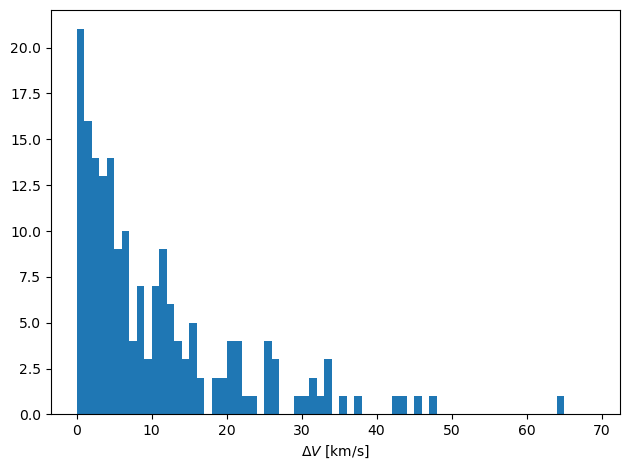

In [10]:
plt.figure(tight_layout=True)

plt.hist(np.abs(delta_z*c).value, bins=np.arange(0,70,1))

plt.xlabel('$\Delta V$ [km/s]');

All of the positions of these observations look good.  The two largest ones show a slight offset from the center of the galaxy (although still well close to the center of the nucleus).  However, their ($\alpha$, $\delta$) coordinates are identical, so we can't determine which is "more centered."

# Calculate the rotational velocities

In [11]:
fuji_axis['V_ROT'] = np.nan
fuji_axis['V_ROT_ERR'] = np.nan
fuji_axis['CENTER_TARGETID'] = 0
fuji_axis['CENTER_TARGETID'].dtype = np.int64

# For each SGA galaxy that has at least one good center observation, calculate 
# the rotational velocity for all of that galaxy's targets
for sga_id in np.unique(good_centers['SGA_ID']):
    
    # Identify all galaxy targets on this galaxy
    obs_idx = fuji_axis['SGA_ID'] == sga_id
    
    # Find galaxy index in SGA catalog
    sga_idx = SGA_dict[sga_id]
    
    #---------------------------------------------------------------------------
    # Calculate rotational velocity
    #---------------------------------------------------------------------------
    # Use the average redshift of all of the center observations for the 
    # systemic velocity
    z_center = SGA['Z_DESI'][sga_idx]
    z_err_center2 = SGA['ZERR_DESI'][sga_idx]**2
    
    # Calculate the rotational velocity for all observations of the galaxy
    # fuji_axis['V_ROT'][obs_idx] = c*(fuji_axis['Z'][obs_idx] - z_center)
    # fuji_axis['V_ROT_ERR'][obs_idx] = c*np.sqrt(fuji_axis['ZERR'][obs_idx]**2 + z_err_center2)
    z_rot = (1 + fuji_axis['Z'][obs_idx])/(1 + z_center) - 1
    fuji_axis['V_ROT'][obs_idx] = c*z_rot
    fuji_axis['V_ROT_ERR'][obs_idx] = c*np.sqrt((fuji_axis['ZERR'][obs_idx]/(1 + z_center))**2 + z_err_center2*((1 + fuji_axis['Z'][obs_idx])/(1 + z_center)**2))
    #---------------------------------------------------------------------------
    
    
    #---------------------------------------------------------------------------
    # Correct rotational velocities for inclination angle
    #---------------------------------------------------------------------------
    cosi2 = (SGA['BA'][sga_idx]**2 - q0**2)/(1 - q0**2)
    
    # Galaxies with b/a < q0
    if cosi2 < 0:
        cosi2 = 0.
        
    fuji_axis['V_ROT'][obs_idx] /= np.sin(np.arccos(np.sqrt(cosi2)))
    #---------------------------------------------------------------------------
    
    
    #---------------------------------------------------------------------------
    # Set center TARGETID in table
    #---------------------------------------------------------------------------
    centers_idx = good_centers['SGA_ID'] == sga_id
    
    if sum(centers_idx) > 1:
        # Take the smaller TARGETID - more likely to be main survey and not backup
        fuji_axis['CENTER_TARGETID'][obs_idx] = np.min(good_centers['TARGETID'][centers_idx])
    else:
        fuji_axis['CENTER_TARGETID'][obs_idx] = good_centers['TARGETID'][centers_idx]
    #---------------------------------------------------------------------------

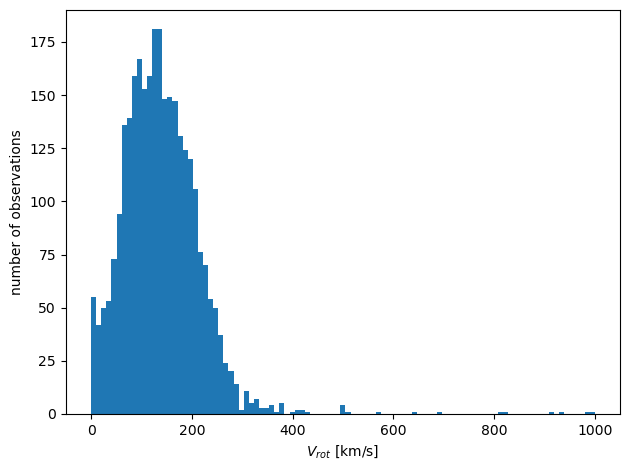

In [12]:
plt.figure(tight_layout=True)

plt.hist(np.abs(fuji_axis['V_ROT']), bins=np.linspace(0, 1000, 100))

plt.xlabel('$V_{rot}$ [km/s]')
plt.ylabel('number of observations');

# Cut for galaxies suitable for the TFR

Requirements:
* $10 < V_{rot} < 1000$ km/s at $0.33R_{26}$
* `ZWARN` != [SKY, UNPLUGGED, BAD_TARGET, NODATA]

## Velocity cut

In [13]:
r0p3 = (fuji_axis['SKY_FIBER_DIST_R26'] > 0.3) & (fuji_axis['SKY_FIBER_DIST_R26'] < 0.4)

Vgood = (np.abs(fuji_axis['V_ROT']) < 1000) & (np.abs(fuji_axis['V_ROT']) >= 10)

good_axis = fuji_axis[r0p3 & Vgood]

print(len(good_axis), len(np.unique(good_axis['SGA_ID'])))

2333 1204


## `ZWARN` cut

In [14]:
ZWARNBITS = dict(
    SKY               = 2**0,  #- sky fiber
    LITTLE_COVERAGE   = 2**1,  #- too little wavelength coverage
    SMALL_DELTA_CHI2  = 2**2,  #- chi-squared of best fit is too close to that of second best
    NEGATIVE_MODEL    = 2**3,  #- synthetic spectrum is negative
    MANY_OUTLIERS     = 2**4,  #- fraction of points more than 5 sigma away from best model is too large (>0.05)
    Z_FITLIMIT        = 2**5,  #- chi-squared minimum at edge of the redshift fitting range
    NEGATIVE_EMISSION = 2**6,  #- a QSO line exhibits negative emission, triggered only in QSO spectra, if  C_IV, C_III, Mg_II, H_beta, or H_alpha has LINEAREA + 3 * LINEAREA_ERR < 0
    UNPLUGGED         = 2**7,  #- the fiber was unplugged/broken, so no spectrum obtained
    BAD_TARGET        = 2**8,  #- catastrophically bad targeting data
    NODATA            = 2**9,  #- No data for this fiber, e.g. because spectrograph was broken during this exposure (ivar=0 for all pixels)
    BAD_MINFIT        = 2**10, #- Bad parabola fit to the chi2 minimum
    POORDATA          = 2**11, #- Poor input data quality but try fitting anyway
    #- The following bits are reserved for experiment-specific post-redrock
    #- afterburner updates to ZWARN; redrock commits to *not* setting these bits
    RESERVED16        = 2**16,
    RESERVED17        = 2**17,
    RESERVED18        = 2**18,
    RESERVED19        = 2**19,
    RESERVED20        = 2**20,
    RESERVED21        = 2**21,
    RESERVED22        = 2**22,
    RESERVED23        = 2**23
)

In [15]:
zwarn_reject = good_axis['ZWARN'] & (ZWARNBITS['SKY'] | ZWARNBITS['UNPLUGGED'] | ZWARNBITS['BAD_TARGET'] | ZWARNBITS['NODATA']) != 0

good_axis_zwarn = good_axis[~zwarn_reject]

print(len(good_axis_zwarn), len(np.unique(good_axis_zwarn['SGA_ID'])))

2333 1204


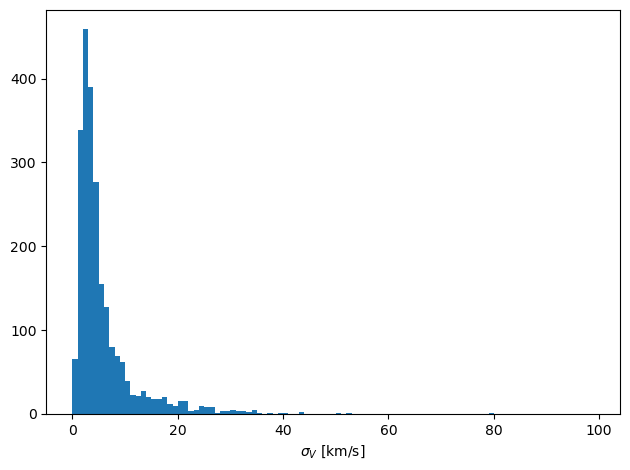

In [16]:
plt.figure(tight_layout=True)

plt.hist(good_axis['V_ROT_ERR'], bins=np.arange(0,100,1))

plt.xlabel('$\sigma_V$ [km/s]');

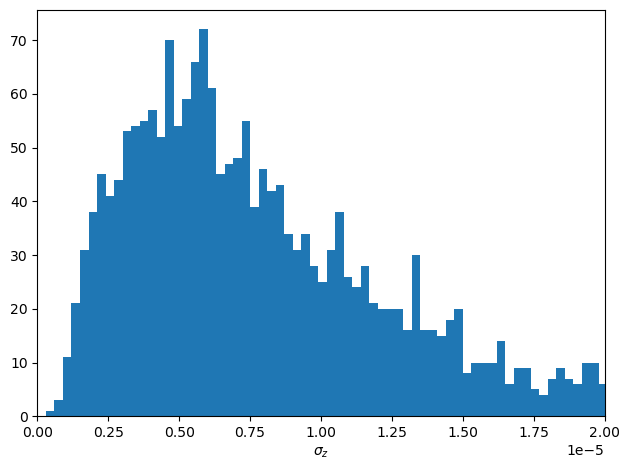

In [17]:
plt.figure(tight_layout=True)

plt.hist(good_axis['ZERR'], bins=np.arange(0,0.0001,0.0000003))

plt.xlim([0, 0.00002])
# plt.xscale('log')
plt.xlabel('$\sigma_z$');

In [18]:
# good_axis[['ZWARN', 'DELTACHI2', 'ZERR', 'V_ROT_ERR']][good_axis['ZERR'] < 1e-10].show_in_notebook()
np.unique(good_axis['ZWARN'])

0
2
4
6
2048


In [19]:
good_axis.sort('SGA_ID')
good_axis[:10]

TARGETID,TARGET_RA,TARGET_DEC,HEALPIX,SURVEY,Z,ZERR,ZWARN,DELTACHI2,FILENAME,PVTYPE,SGA_ID,RA,DEC,SKY_FIBER_DIST,SKY_FIBER_DIST_R26,V_ROT,V_ROT_ERR,CENTER_TARGETID
int64,float64,float64,int64,bytes3,float64,float64,int64,float64,bytes63,bytes3,int64,float64,float64,float64,float64,float64,float64,int64
1070144189104132,180.383498876859,1.29621479718706,27649,sv3,0.0222944544366663,2.83413346431536e-05,0,45.697032826487,fuji/healpix/sv3/bright/276/27649/redrock-sv3-bright-27649.fits,TFT,896,180.38349887685897,1.2962147971870641,0.0017158577471342445,0.3299999976952252,-63.81304840380153,11.025413056954893,39627817951955633
1070869912748034,252.860062744453,33.03565124542,9337,sv3,0.0625669112434631,7.42303672319939e-06,0,437.830720379949,fuji/healpix/sv3/bright/93/9337/redrock-sv3-bright-9337.fits,TFT,1548,252.86006274445305,33.035651245420034,0.0014817091303669227,0.32999998844205425,144.7764362872882,3.1037522857295525,39632941722111933
1084271934570499,236.813448650733,43.9957553864163,9923,sv3,0.0353008322684175,9.4825361822116e-06,0,335.291149647906,fuji/healpix/sv3/dark/99/9923/redrock-sv3-dark-9923.fits,TFT,1583,236.8134486507333,43.99575538641631,0.0012179991251851686,0.3300000066379492,-64.82560850229697,3.309608031930272,39633149604397504
1071077795037187,236.813448650733,43.9957553864163,9923,sv3,0.0352887795291414,7.31620291911626e-06,0,550.152345106006,fuji/healpix/sv3/bright/99/9923/redrock-sv3-bright-9923.fits,TFT,1583,236.8134486507333,43.99575538641631,0.0012179991251851686,0.3300000066379492,-69.4276935807466,2.811225389327452,39633149604397504
1071077795037186,236.810202992035,43.9950609278788,9923,sv3,0.0356212945166845,2.64003527378348e-05,0,36.7676933435723,fuji/healpix/sv3/bright/99/9923/redrock-sv3-bright-9923.fits,TFT,1583,236.81020299203462,43.99506092787884,0.0012179991251745326,0.33000000663506757,57.53616313974273,7.863871509652622,39633149604397504
1070114673786883,221.075749843622,0.0468221575847811,25945,sv3,0.0281530939872011,3.2224441075336e-05,0,17.8997257928131,fuji/healpix/sv3/bright/259/25945/redrock-sv3-bright-25945.fits,TFT,1980,221.07574984362205,0.04682215758478109,0.0028842032592407145,0.33000000046500755,-146.349918862414,9.437769865776852,39627788436637485
1070114673786884,221.077296137197,0.0412648658561053,25945,sv3,0.0288180099915314,7.19422906153812e-05,0,294.173335613379,fuji/healpix/sv3/bright/259/25945/redrock-sv3-bright-25945.fits,TFT,1980,221.0772961371969,0.041264865856105344,0.0028842032592422575,0.3300000004651841,809.7839716918164,20.994228894400674,39627788436637485
1071051379310601,240.336624731033,42.4918899658903,9831,sv3,0.0444399721652274,4.82991172826928e-06,0,1253.83462938666,fuji/healpix/sv3/bright/98/9831/redrock-sv3-bright-9831.fits,TFT,2497,240.33662473103297,42.49188996589028,0.0013625365270653644,0.3300000107903874,182.77150454144396,1.9776964857347676,39633123188672133
1084245518843914,240.340176299163,42.4911365281518,9831,sv3,0.0435862955550485,3.6511432655708e-06,0,2576.21175398212,fuji/healpix/sv3/dark/98/9831/redrock-sv3-dark-9831.fits,TFT,2497,240.3401762991628,42.4911365281518,0.0013625365270700028,0.33000001079151076,-206.39846707519737,1.756518354717397,39633123188672133


In [20]:
good_axis.write('/global/cfs/projectdirs/desi/science/td/pv/desi_pv_tf_fuji_good-axis.fits', overwrite=True)

### How do the velocities compare for objects that have multiple observations?

Also, keep track of those which would get cut by our $\Delta V / V_\text{min} < 5$ requirement. 

In [20]:
# Redrock systematic duplicate redshift uncertainty
dv_sys = 7 # km/s

In [21]:
n = 0

delta_v = np.array([])
delta_v_norm_min = np.array([])
delta_v_norm_sigma = np.array([])
deltachi2 = np.array([])
sigma_v = np.array([])
v_norm_min = np.array([])
v_norm_max = np.array([])

good_deltaVs = np.array([])
good_deltaV_norm_sigma = np.array([])

# For observations made on the same side of the galaxy
same_delta_v = np.array([])
same_delta_v_norm_min = np.array([])
same_delta_v_norm_sigma = np.array([])
# same_deltachi2 = np.array([])
# same_v_norm_min = np.array([])
# same_v_norm_max = np.array([])

# same_good_deltaVs = np.array([])
# same_good_deltaV_norm_sigma = np.array([])

# For observations made on opposite sides of the galaxy
opposite_delta_v = np.array([])
opposite_delta_v_norm_min = np.array([])
opposite_delta_v_norm_sigma = np.array([])
# opposite_deltachi2 = np.array([])
# opposite_v_norm_min = np.array([])
# opposite_v_norm_max = np.array([])

# opposite_good_deltaVs = np.array([])
# opposite_good_deltaV_norm_sigma = np.array([])

deltachi2_idx = good_axis['DELTACHI2'] >= 25

for sga_id in np.unique(good_axis['SGA_ID']):
    
    # Identify all galaxy targets on this galaxy
    obs_idx = good_axis['SGA_ID'] == sga_id
    
    n_obs = np.sum(obs_idx)
    
    if n_obs > 1:

        # Make a copy of table with just this galaxy's observations
        this_gal = good_axis[obs_idx]
        
        v_min = np.min(np.abs(this_gal['V_ROT']))
        v_max = np.max(np.abs(this_gal['V_ROT']))
        
        v_norm_min = np.append(v_norm_min, np.abs(this_gal['V_ROT'])/v_min)
        v_norm_max = np.append(v_norm_max, np.abs(this_gal['V_ROT'])/v_max)
        
        deltachi2 = np.append(deltachi2, this_gal['DELTACHI2'])
        sigma_v = np.append(sigma_v, this_gal['V_ROT_ERR'])
        
        diff_matrix = np.abs(this_gal['V_ROT']).reshape(n_obs,1) - np.abs(this_gal['V_ROT']).reshape(1,n_obs)
        
        diff_matrix_norm = diff_matrix/v_min
        
        sigma_matrix = np.sqrt(this_gal['V_ROT_ERR'].reshape(n_obs,1)**2 + this_gal['V_ROT_ERR'].reshape(1,n_obs)**2 + dv_sys**2)
        
        diffs = diff_matrix[np.triu_indices(n_obs, k=1)]
        
        sigmas = sigma_matrix[np.triu_indices(n_obs, k=1)]
        
        diffs_norm = diffs/v_min
        
        diffs_norm_sigma = diffs/sigmas
        
        delta_v = np.append(delta_v, diffs)
        
        delta_v_norm_min = np.append(delta_v_norm_min, diffs_norm)
        
        delta_v_norm_sigma = np.append(delta_v_norm_sigma, diffs_norm_sigma)
        
        # Compare observations made on same or opposite side of galaxy
        for i in range(n_obs):
            for j in range(i+1, n_obs):
                
                diff = np.abs(this_gal['V_ROT'][i]) - np.abs(this_gal['V_ROT'][j])
                sigma = np.sqrt(this_gal['V_ROT_ERR'][i]**2 + this_gal['V_ROT_ERR'][j]**2 + dv_sys**2)
                '''
                delta_v = np.append(delta_v, diff)
                delta_v_norm_min = np.append(delta_v_norm_min, diff/v_min)
                delta_v_norm_sigma = np.append(delta_v_norm_sigma, diff/sigma)
                '''
                # Same side of galaxy
                if (this_gal['TARGET_RA'][i] == this_gal['TARGET_RA'][j]) & (this_gal['TARGET_DEC'][i] == this_gal['TARGET_DEC'][j]):
                    same_delta_v = np.append(same_delta_v, diff)
                    same_delta_v_norm_min = np.append(same_delta_v_norm_min, diff/v_min)
                    same_delta_v_norm_sigma = np.append(same_delta_v_norm_sigma, diff/sigma)
                
                # Opposite side of galaxy
                else:
                    opposite_delta_v = np.append(opposite_delta_v, diff)
                    opposite_delta_v_norm_min = np.append(opposite_delta_v_norm_min, diff/v_min)
                    opposite_delta_v_norm_sigma = np.append(opposite_delta_v_norm_sigma, diff/sigma)
        '''
        # if np.any(np.abs(diffs_norm) > 5.):
        # if np.any(np.abs(diffs) > 50.):
        if np.any(np.abs(diffs_norm_sigma) > 50.):

            print(sga_id)
            print(diffs, diffs_norm, diffs_norm_sigma)
            print(good_axis[['TARGETID', 'RA', 'DEC', 'V_ROT', 'V_ROT_ERR', 'PVTYPE', 'FILENAME', 'DELTACHI2', 'ZWARN']][obs_idx].pprint(max_width=-1))
        '''
        
        ########################################################################
        # For Delta V / Vmin cut
        #-----------------------------------------------------------------------
        if np.any(np.abs(diff_matrix_norm) > 5):
            
            # Remove all observations with DELTACHI2 < 25
            # Note: This also typically removes observations with ZWARN != 0
            good_obs_idx = obs_idx & deltachi2_idx
            
            n_obs_good = np.sum(good_obs_idx)
            
            # Check to make sure that, if there are still multiple observations, 
            # they all satisfy our relative velocity criteria
            if n_obs_good > 1:
                
                Vmin = np.min(np.abs(good_axis['V_ROT'][good_obs_idx]))
                
                diff_matrix = np.abs(good_axis['V_ROT'][good_obs_idx]).reshape(n_obs_good, 1) - np.abs(good_axis['V_ROT'][good_obs_idx]).reshape(1, n_obs_good)
                
                diff_matrix_norm = diff_matrix/Vmin
                
                if np.all(np.abs(diff_matrix_norm) <= 5):
                    
                    sigma_matrix = np.sqrt(good_axis['V_ROT_ERR'][good_obs_idx].reshape(n_obs_good,1)**2 + good_axis['V_ROT_ERR'][good_obs_idx].reshape(1,n_obs_good)**2)
                    
                    good_deltaVs = np.append(good_deltaVs, diff_matrix[np.triu_indices(n_obs_good, k=1)])
                    good_deltaV_norm_sigma = np.append(good_deltaV_norm_sigma, 
                                                       diff_matrix[np.triu_indices(n_obs_good, k=1)]/sigma_matrix[np.triu_indices(n_obs_good, k=1)])
        else:
            good_deltaVs = np.append(good_deltaVs, diffs)
            good_deltaV_norm_sigma = np.append(good_deltaV_norm_sigma, diffs_norm_sigma)
        ########################################################################
        
        n += 1
        
print(n)

727


In [22]:
print(len(same_delta_v), len(opposite_delta_v))
print(len(delta_v))

519 1124
1643


#### Plot a histogram of the difference in rotational velocities

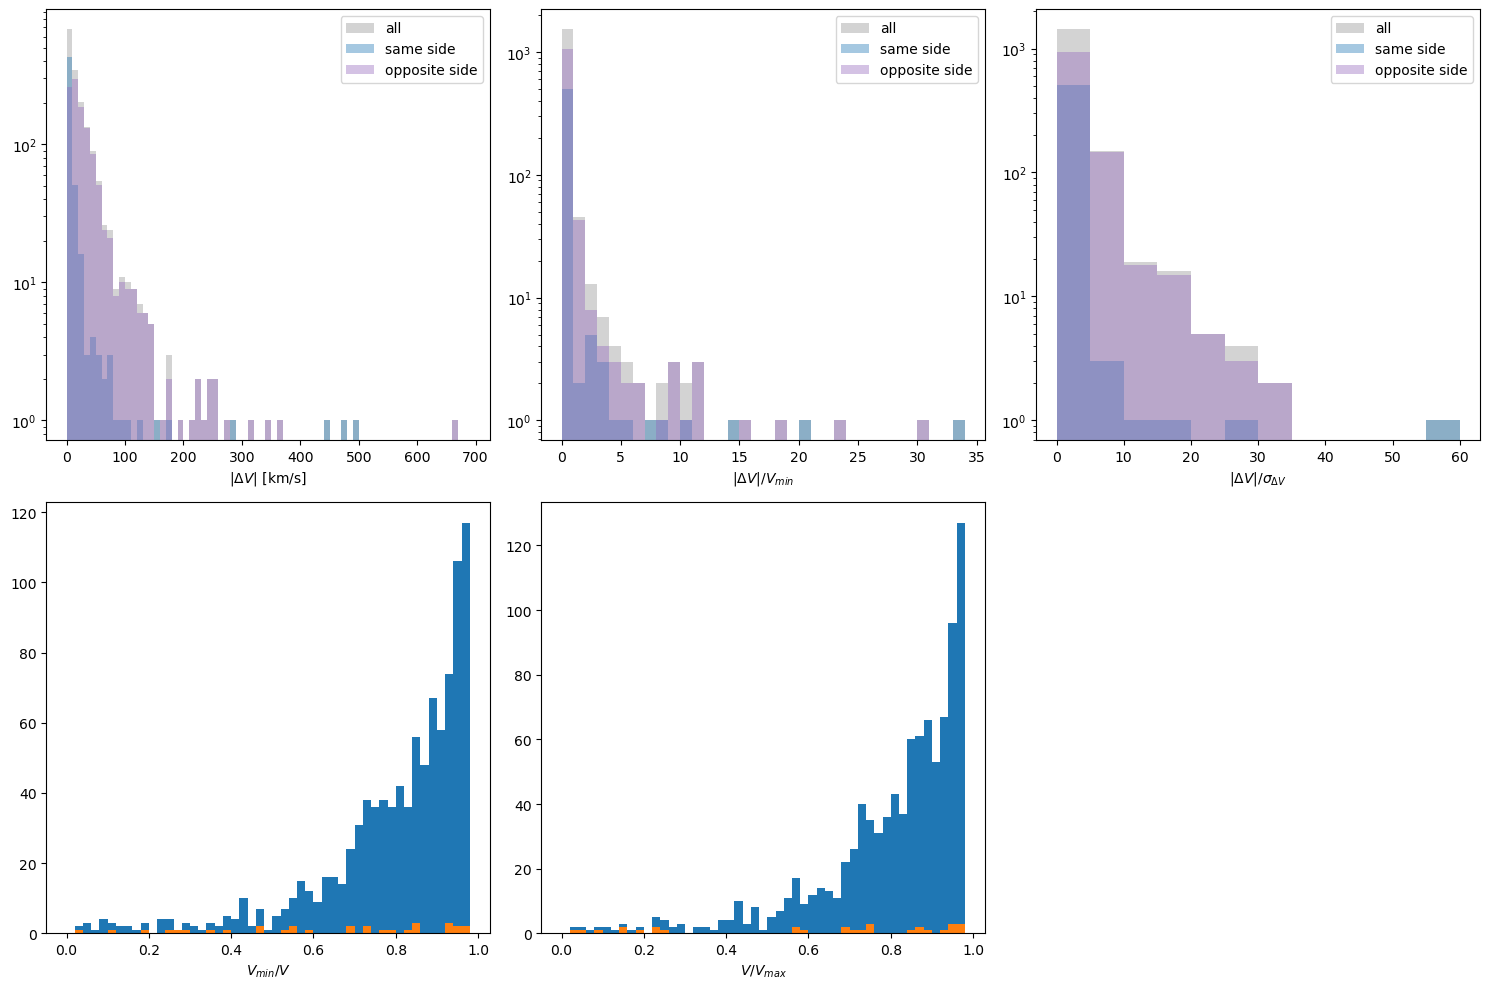

In [23]:
plt.figure(tight_layout=True, figsize=(15,10))


#-------------------------------------------------------------------------------
plt.subplot(231)

plt.hist(np.abs(delta_v), color='lightgray', bins=np.arange(0,700,10), label='all')
plt.hist(np.abs(same_delta_v), color='tab:blue', alpha=0.4, bins=np.arange(0,700,10), label='same side')
plt.hist(np.abs(opposite_delta_v), color='tab:purple', alpha=0.4, bins=np.arange(0,700,10), label='opposite side')

plt.yscale('log')

plt.legend()

plt.xlabel('|$\Delta V$| [km/s]')
#-------------------------------------------------------------------------------


#-------------------------------------------------------------------------------
plt.subplot(232)

plt.hist(np.abs(delta_v_norm_min), color='lightgray', bins=np.arange(0,35,1), label='all')
plt.hist(np.abs(same_delta_v_norm_min), color='tab:blue', alpha=0.4, bins=np.arange(0,35,1), label='same side')
plt.hist(np.abs(opposite_delta_v_norm_min), color='tab:purple', alpha=0.4, bins=np.arange(0,35,1), label='opposite side')

plt.yscale('log')

plt.legend()

plt.xlabel('$|\Delta V| / V_{min}$')
#-------------------------------------------------------------------------------


#-------------------------------------------------------------------------------
plt.subplot(233)

plt.hist(np.abs(delta_v_norm_sigma), color='lightgray', bins=np.arange(0,65,5), label='all')
plt.hist(np.abs(same_delta_v_norm_sigma), color='tab:blue', alpha=0.4, bins=np.arange(0,65,5), label='same side')
plt.hist(np.abs(opposite_delta_v_norm_sigma), color='tab:purple', alpha=0.4, bins=np.arange(0,65,5), label='opposite side')

plt.yscale('log')

plt.legend()

plt.xlabel('$|\Delta V| / \sigma_{\Delta V}$')
#-------------------------------------------------------------------------------


#-------------------------------------------------------------------------------
plt.subplot(234)

plt.hist(1/v_norm_min, bins=np.arange(0,1,0.02))
plt.hist(1/v_norm_min[deltachi2 < 25], bins=np.arange(0,1,0.02))

#plt.yscale('log')

plt.xlabel('$V_{min} / V$')
#-------------------------------------------------------------------------------


#-------------------------------------------------------------------------------
plt.subplot(235)

plt.hist(v_norm_max, bins=np.arange(0,1,0.02))
plt.hist(v_norm_max[deltachi2 < 25], bins=np.arange(0,1,0.02))

#plt.yscale('log')

plt.xlabel('$V / V_{max}$');
#-------------------------------------------------------------------------------

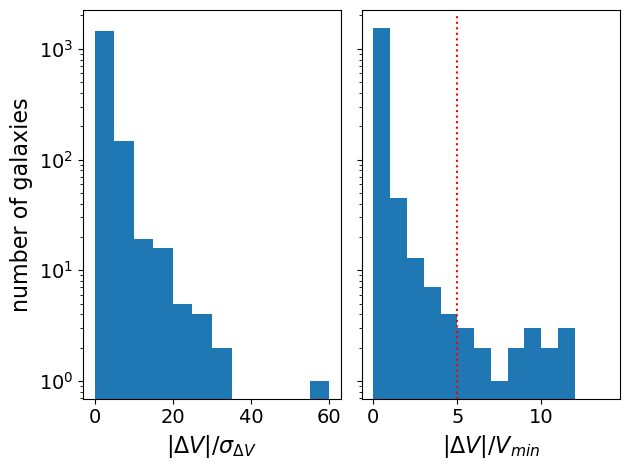

In [24]:
plt.figure(tight_layout=True)


ax1 = plt.subplot(121)
'''
plt.hist(np.abs(delta_v), bins=np.arange(0,600,20))
# plt.hist(np.abs(good_deltaVs), fill=False, hatch='x', bins=np.arange(0,600,20))
plt.xlabel('$\Delta V$ [km/s]', fontsize=16)
'''
plt.hist(np.abs(delta_v_norm_sigma), bins=np.arange(0, 65, 5))
# plt.hist(np.abs(good_deltaV_norm_sigma), fill=False, hatch='x', bins=np.arange(0, 125, 5))
plt.xlabel('$|\Delta V| / \sigma_{\Delta V}$', fontsize=16)

plt.yscale('log')
# plt.ylim([0, 1600])
plt.tick_params(axis='both', which='major', labelsize=14)
plt.ylabel('number of galaxies', fontsize=16)


ax2 = plt.subplot(122, sharey=ax1)
plt.hist(np.abs(delta_v_norm_min), bins=np.arange(0,15,1))
plt.vlines(5, 0, 2000, colors='r', linestyles='dotted')
plt.tick_params('x', which='major', labelsize=14)
plt.tick_params('y', labelleft=False)
plt.xlabel('$|\Delta V| / V_{min}$', fontsize=16);

# plt.savefig('../../Figures/SV/fuji_deltaVlog_20240619.png', dpi=150);

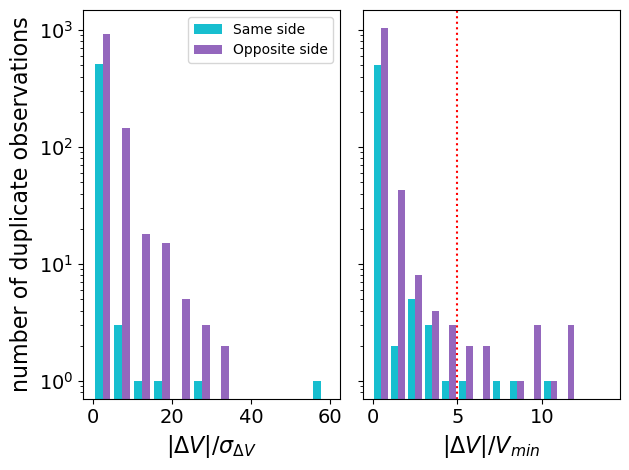

In [25]:
plt.figure(tight_layout=True)


ax1 = plt.subplot(121)
plt.hist([np.abs(same_delta_v_norm_sigma), np.abs(opposite_delta_v_norm_sigma)], 
         color=['tab:cyan', 'tab:purple'],
         bins=np.arange(0,65,5), 
         # stacked=True, 
         label=['Same side', 'Opposite side'])
plt.xlabel('$|\Delta V| / \sigma_{\Delta V}$', fontsize=16)

plt.legend()

plt.yscale('log')
# plt.ylim([0, 1600])
plt.tick_params(axis='both', which='major', labelsize=14)
plt.ylabel('number of duplicate observations', fontsize=16)


ax2 = plt.subplot(122, sharey=ax1)
plt.hist([np.abs(same_delta_v_norm_min), np.abs(opposite_delta_v_norm_min)], 
         color=['tab:cyan', 'tab:purple'],
         bins=np.arange(0,15,1), 
         # stacked=True
        )
plt.vlines(5, 0, 4000, colors='r', linestyles='dotted')
plt.tick_params('x', which='major', labelsize=14)
plt.tick_params('y', labelleft=False)
plt.xlabel('$|\Delta V| / V_{min}$', fontsize=16);

plt.savefig('../../Figures/SV/fuji_deltaVlog_sameVopposite_20241010.png', dpi=150);

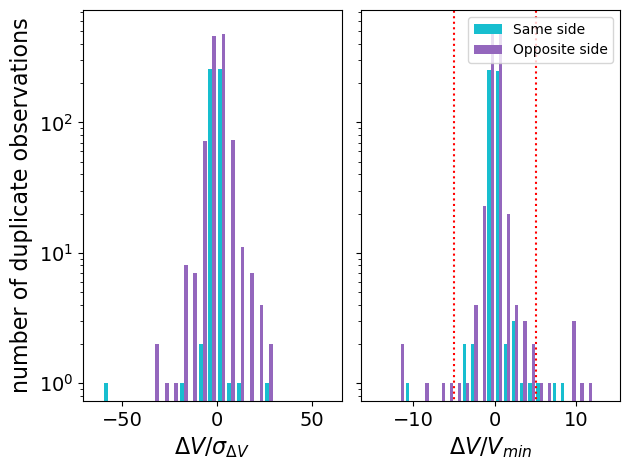

In [30]:
plt.figure(tight_layout=True)


ax1 = plt.subplot(121)
plt.hist([same_delta_v_norm_sigma, opposite_delta_v_norm_sigma], 
         color=['tab:cyan', 'tab:purple'],
         bins=np.arange(-65,65,5), 
         # stacked=True, 
         label=['Same side', 'Opposite side'])
plt.xlabel('$\Delta V / \sigma_{\Delta V}$', fontsize=16)

# plt.legend()

plt.yscale('log')
# plt.ylim([0, 1600])
plt.tick_params(axis='both', which='major', labelsize=14)
plt.ylabel('number of duplicate observations', fontsize=16)


ax2 = plt.subplot(122, sharey=ax1)
plt.hist([same_delta_v_norm_min, opposite_delta_v_norm_min], 
         color=['tab:cyan', 'tab:purple'],
         bins=np.arange(-15,15,1), 
         # stacked=True
         label=['Same side', 'Opposite side']
        )
plt.vlines([-5, 5], 0, 4000, colors='r', linestyles='dotted')

plt.legend()

plt.tick_params('x', which='major', labelsize=14)
plt.tick_params('y', labelleft=False)
plt.xlabel('$\Delta V / V_{min}$', fontsize=16);

# plt.savefig('../../Figures/SV/fuji_deltaVlog_20240619.png', dpi=150);

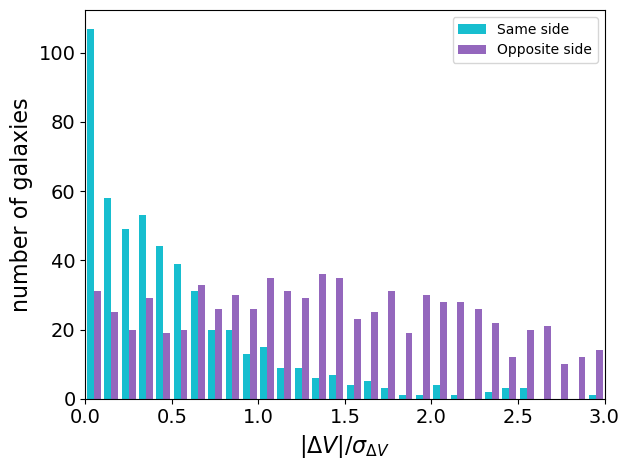

In [26]:
plt.figure(tight_layout=True)

# plt.grid()

# plt.hist(np.abs(delta_v_norm_sigma), bins=np.arange(0, 125, 0.1))
plt.hist([np.abs(same_delta_v_norm_sigma), np.abs(opposite_delta_v_norm_sigma)], 
         bins=np.arange(0, 65, 0.1), 
         color=['tab:cyan', 'tab:purple'], 
         # stacked=True, 
         label=['Same side', 'Opposite side'])
plt.xlabel('$|\Delta V| / \sigma_{\Delta V}$', fontsize=16)

plt.legend()

plt.xlim([0, 3])

plt.tick_params(axis='both', which='major', labelsize=14)
plt.ylabel('number of galaxies', fontsize=16);

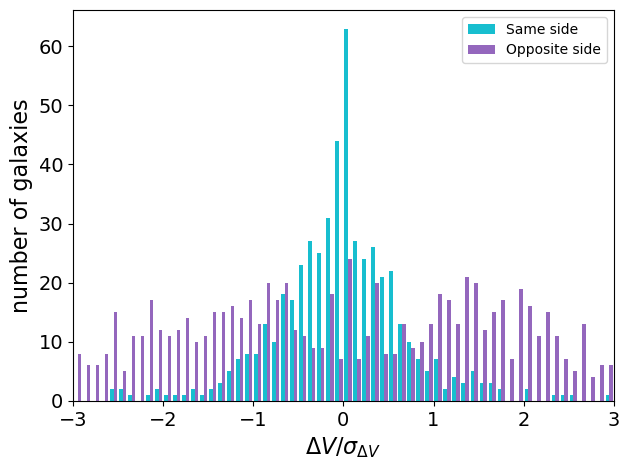

In [28]:
plt.figure(tight_layout=True)

# plt.grid()

# plt.hist(np.abs(delta_v_norm_sigma), bins=np.arange(0, 125, 0.1))
plt.hist([same_delta_v_norm_sigma, opposite_delta_v_norm_sigma], 
         bins=np.arange(-65, 65, 0.1), 
         color=['tab:cyan', 'tab:purple'], 
         # stacked=True, 
         label=['Same side', 'Opposite side'])
plt.xlabel('$\Delta V / \sigma_{\Delta V}$', fontsize=16)

plt.legend()

plt.xlim([-3, 3])

plt.tick_params(axis='both', which='major', labelsize=14)
plt.ylabel('number of galaxies', fontsize=16);

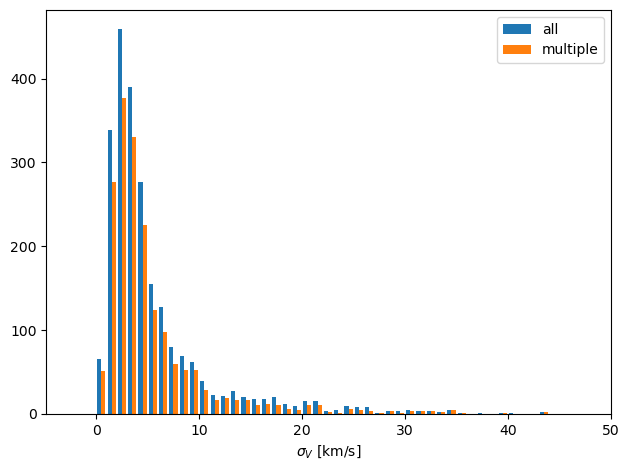

In [33]:
plt.figure(tight_layout=True)

plt.hist([good_axis['V_ROT_ERR'], sigma_v], 
         bins=np.arange(0,100,1), 
         label=['all', 'multiple'])

plt.xlim(xmax=50)

plt.legend()

plt.xlabel('$\sigma_V$ [km/s]');

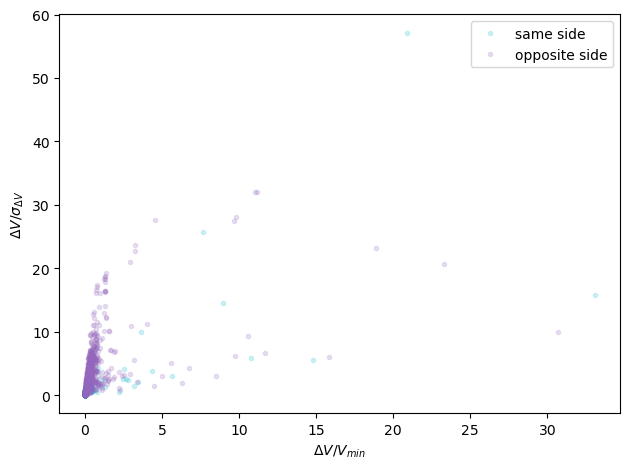

In [32]:
plt.figure(tight_layout=True)

# plt.plot(np.abs(delta_v_norm_min), np.abs(delta_v_norm_sigma), '.', alpha=0.2)
plt.plot(np.abs(same_delta_v_norm_min), np.abs(same_delta_v_norm_sigma), '.', c='tab:cyan', alpha=0.2, label='same side')
plt.plot(np.abs(opposite_delta_v_norm_min), np.abs(opposite_delta_v_norm_sigma), '.', c='tab:purple', alpha=0.2, label='opposite side')

plt.legend()

plt.xlabel('$\Delta V / V_{min}$')
plt.ylabel('$\Delta V / \sigma_{\Delta V}$');

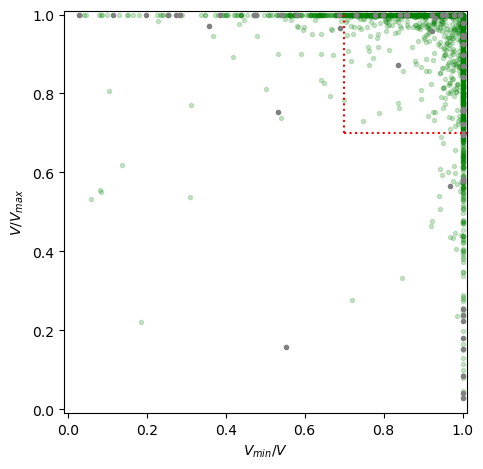

In [30]:
plt.figure(tight_layout=True)

plt.plot(1/v_norm_min[deltachi2 >= 25], v_norm_max[deltachi2 >= 25], 'g.', alpha=0.2)
plt.plot(1/v_norm_min[deltachi2 < 25], v_norm_max[deltachi2 < 25], '.', c='gray')

plt.hlines(0.7, 0.7, 1.1, colors='r', linestyles=':')
plt.vlines(0.7, 0.7, 1.1, colors='r', linestyles=':')

plt.gca().set_aspect('equal', 'box')

plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])

plt.xlabel('$V_{min} / V$')
plt.ylabel('$V / V_{max}$');